In [ ]:
import numpy as np
from numpy.linalg import inv
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [ ]:
# target_coord = np.array([[ 93, 81],
#                 [ 87, 55],
#                 [163, 39],
#                 [131, 101]])

# source_coord = np.array([[ 97 ,283],
#                 [ 92 ,257],
#                 [169 ,240],
#                 [138 ,303]])

target_coord = np.array([[92,80],
                        [86,55],
                        [82,33],
                        [131,100],
                        [109,53],
                        [164,37],
                        [179,28]])

source_coord = np.array([[97,283],
                        [93,259],
                        [89,236],
                        [138,303],
                        [117,256],
                        [169,239],
                        [183,229]])


M = []
for i in range(source_coord.shape[0]):
    M.append([-source_coord[i][0],-source_coord[i][1],-1,0,0,0,source_coord[i][0]*target_coord[i][0],source_coord[i][1]*target_coord[i][0]])
    
for i in range(source_coord.shape[0]):
    M.append([0,0,0,-source_coord[i][0],-source_coord[i][1],-1,source_coord[i][0]*target_coord[i][1],source_coord[i][1]*target_coord[i][1]])    

q = []

for i in range(target_coord.shape[0]):
    q.append(-target_coord[i][0])
for i in range(target_coord.shape[0]):
    q.append(-target_coord[i][1])
               
q = np.asarray(q)
q = q.reshape(q.shape[0],1)

# M = np.array(M)
# q = np.array(q)
# MT = M.transpose()
# MInverse = inv(np.matmul(MT,M))
# S1 = np.matmul(MInverse,MT)
# p = np.matmul(S1,q)
# print(p)
p = np.linalg.lstsq(M,q,rcond=-1)[0]
print(p)
print(p.shape)

[[ 8.89627576e-01]
 [ 4.88474123e-02]
 [-8.87792087e+00]
 [-1.05006106e-02]
 [ 9.82996219e-01]
 [-1.98040077e+02]
 [-7.77515723e-04]
 [ 2.83393016e-04]]
(8, 1)


Text(0.5, 1.0, 'Fig 2 - Target Image')

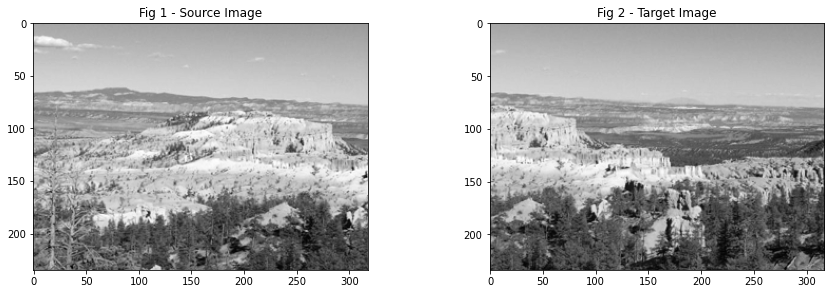

In [ ]:
P = np.array([[p[0][0],p[1][0],p[2][0]],[p[3][0],p[4][0],p[5][0]],[p[6][0],p[7][0],1]])
Pinv = inv(P)
source = cv2.imread('/content/drive/MyDrive/m1.png')
target = cv2.imread('/content/drive/MyDrive/m2.png')
source_gray = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
target_gray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)

source_gray = ((source_gray - np.min(source_gray)) * (1/(np.max(source_gray) - np.min(source_gray)) *1.0)).astype('float')
target_gray = ((target_gray - np.min(target_gray)) * (1/(np.max(target_gray) - np.min(target_gray)) *1.0)).astype('float')

plt.figure(figsize=(15, 10)) 

plt.subplot(221) 
plt.imshow(source_gray, cmap='gray') 
plt.title('Fig 1 - Source Image')

plt.subplot(222) 
plt.imshow(target_gray, cmap='gray') 
plt.title('Fig 2 - Target Image')

In [ ]:
[rows,cols] = target_gray.shape
top_left = Pinv.dot(np.array([0.0, 0.0, 1.0], float))
top_left = top_left / top_left[2]

# Bottom left corner
bottom_left = Pinv.dot(np.array([rows-1.0, 0.0, 1.0], float))
bottom_left = bottom_left / bottom_left[2]

# Top right corner
top_right = Pinv.dot(np.array([0.0, cols-1.0, 1.0], float))
top_right = top_right / top_right[2]

# Bottom right corner
bottom_right = Pinv.dot(np.array([rows-1.0, cols-1.0, 1.0], float))
bottom_right = bottom_right / bottom_right[2]

# Calculate tight bounding box around the transformed corners
min_rows = np.min([top_left[0], bottom_left[0], top_right[0], bottom_right[0]])
max_rows = np.max([top_left[0], bottom_left[0], top_right[0], bottom_right[0]])

min_cols = np.min([top_left[1], bottom_left[1], top_right[1], bottom_right[1]])
max_cols = np.max([top_left[1], bottom_left[1], top_right[1], bottom_right[1]])

# Coordintes to transform for rows and columns
# This creates evenly spaced samples between the min and the max 
out_sampling_rows = np.linspace(math.floor(min_rows), math.ceil(max_rows), math.ceil(max_rows) - math.floor(min_rows)+1)
out_sampling_cols = np.linspace(math.floor(min_cols), math.ceil(max_cols), math.ceil(max_cols) - math.floor(min_cols)+1)

Text(0.5, 1.0, 'Fig 9 - Target Image after Transformation (4 Corresponding Pts.)')

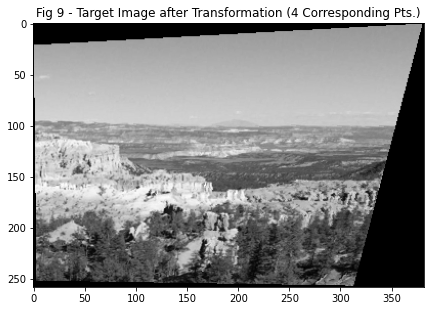

In [ ]:
# Create the blank output canvas 
out = np.zeros((len(out_sampling_rows), len(out_sampling_cols)))

# Visit every pixel on the output canvas (which starts blank)
# Loop over the rows 
for cur_row in range(0, len(out_sampling_rows)):
    # Loop over the cols
    for cur_col in range(0, len(out_sampling_cols)):
        
        # Current world point
        cur_pt = np.array([out_sampling_rows[cur_row], out_sampling_cols[cur_col], 1.0],float)
        
        # Compute the transformed point
        transformed_pt = P.dot(cur_pt)
        # Divide homogeneous coord by w to get Cartesian coord
        transformed_pt = transformed_pt / transformed_pt[2]
        
        # Make sure we don't go off of the original image
        if (np.floor(transformed_pt[0]) < 0 or np.ceil(transformed_pt[0]) >= rows or \
            np.floor(transformed_pt[1]) < 0 or np.ceil(transformed_pt[1]) >= cols):
            continue
                    
        # Nearest neighbor interpolation
        new_row = int(round(transformed_pt[0]))
        new_col = int(round(transformed_pt[1]))
        
        out[cur_row, cur_col] = target_gray[new_row, new_col]
        
# Show the image
fig1 = plt.figure(figsize = (7,7))
plt.imshow(out, cmap='gray')
plt.title('Fig 9 - Target Image after Transformation (4 Corresponding Pts.)')
# for i in range(0, target_gray.shape[0]):
#     for j in range(0, target_gray.shape[1]):
#       if out_im2[i][j] == 0:
#         out_im2[i][j] = target_gray[i][j]

# plt.imshow(out_im2, cmap='gray')



(235, 318)
(234, 317)


Text(0.5, 1.0, 'Fig 10 - Output after Joining Source and Target Images using 4 Corresponding Points')

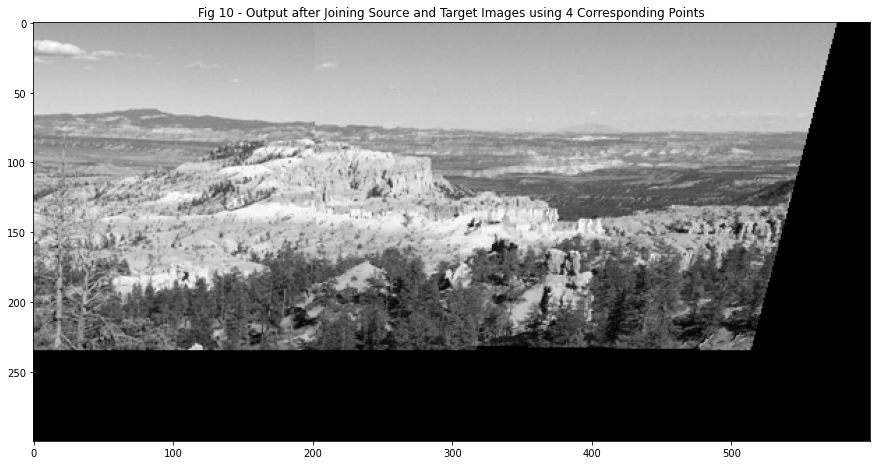

In [ ]:
res = np.zeros((300,600))
M,N = source_gray.shape
print(source_gray.shape)
print(target_gray.shape)
res[0:M,0:N] = source_gray

for i in range(0,300):
  for j in range(0,600):
    cur_pt = np.array([i,j,1])
    transformed_pt = P.dot(cur_pt)
        
    transformed_pt = transformed_pt / transformed_pt[2]
        
    new_i = int(round(transformed_pt[0]))
    new_j = int(round(transformed_pt[1]))
    
    if (new_i < 0 or new_i >= rows or new_j < 0 or new_j >= cols):
      continue
            
    res[i,j] = target_gray[new_i, new_j]

plt.figure(figsize=(15,10))
 
plt.imshow(res,cmap='gray')
plt.title('Fig 10 - Output after Joining Source and Target Images using 4 Corresponding Points')
